# Week 7 - Temporal models 

## Part 2: Road traffic - Time-series forecasting

In this part, we will specify a simple linear dynamical system (LDS) in Pyro in order to forecast freeway occupancy rates. 

As explained in the previous Notebook, we will be using NumPyro throughout this entire Lecture.

The usual imports...

In [18]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns

import numpyro
import numpyro.distributions as dist
from numpyro import handlers
from numpyro.infer import MCMC, NUTS

import jax
import jax.numpy as jnp
from jax import random, vmap
from jax.scipy.special import logsumexp
from jax import lax

import time

# fix MCMCndom generator seed (for reproducibility of results)
np.random.seed(42)

# matplotlib style options
plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 10)

The data consists of time-series of freeway occupancy rates (rows), with length $T=1008$, at 10 different consecutive sensors/detectors (columns). However, for now, we will focus only on the data from a single detector as an example...

Load data:

In [19]:
df = pd.read_csv("http://mlsm.man.dtu.dk/mbml/PeMS_sample.csv")
df.head()

,# detector400000,detector400001,detector400009,detector400010,detector400015,detector400017,detector400025,detector400026,detector400027,detector400030
0,0.0154,0.0054,0.0164,0.0079,0.0059,0.0138,0.0111,0.0156,0.0154,0.0080
1,0.0085,0.0051,0.0127,0.0062,0.0051,0.0125,0.0099,0.0175,0.0134,0.0067
2,0.0099,0.0056,0.0172,0.0068,0.0053,0.0116,0.0105,0.0157,0.0112,0.0065
3,0.0108,0.0045,0.0126,0.0072,0.0058,0.0131,0.0073,0.0146,0.0128,0.0040
4,0.0100,0.0037,0.0185,0.0048,0.0063,0.0099,0.0061,0.0157,0.0123,0.0064


Some basic data statistics:

In [20]:
print("Dataset size:", len(df))
print("General statistics:")
df.describe()

Dataset size: 1008
General statistics:


,# detector400000,detector400001,detector400009,detector400010,detector400015,detector400017,detector400025,detector400026,detector400027,detector400030
count,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.00000,1008.000000
mean,0.049489,0.044541,0.066207,0.051599,0.026812,0.047976,0.037051,0.055881,0.05583,0.049262
std,0.030016,0.047490,0.047321,0.040934,0.019402,0.052455,0.036248,0.049275,0.04192,0.042152
min,0.005300,0.000000,0.000000,0.000000,0.001900,0.002200,0.002900,0.002500,0.00150,0.001500
25%,0.027150,0.014900,0.029525,0.018000,0.013100,0.014775,0.012075,0.017950,0.01820,0.027075
50%,0.055300,0.038600,0.070500,0.046400,0.021700,0.038750,0.029000,0.051500,0.05665,0.046700
75%,0.064400,0.051900,0.088025,0.070800,0.030925,0.054125,0.045400,0.069825,0.07670,0.058925
max,0.317600,0.355000,0.393600,0.232700,0.094900,0.316900,0.197200,0.307400,0.22060,0.408100


Visualize data (part of it):

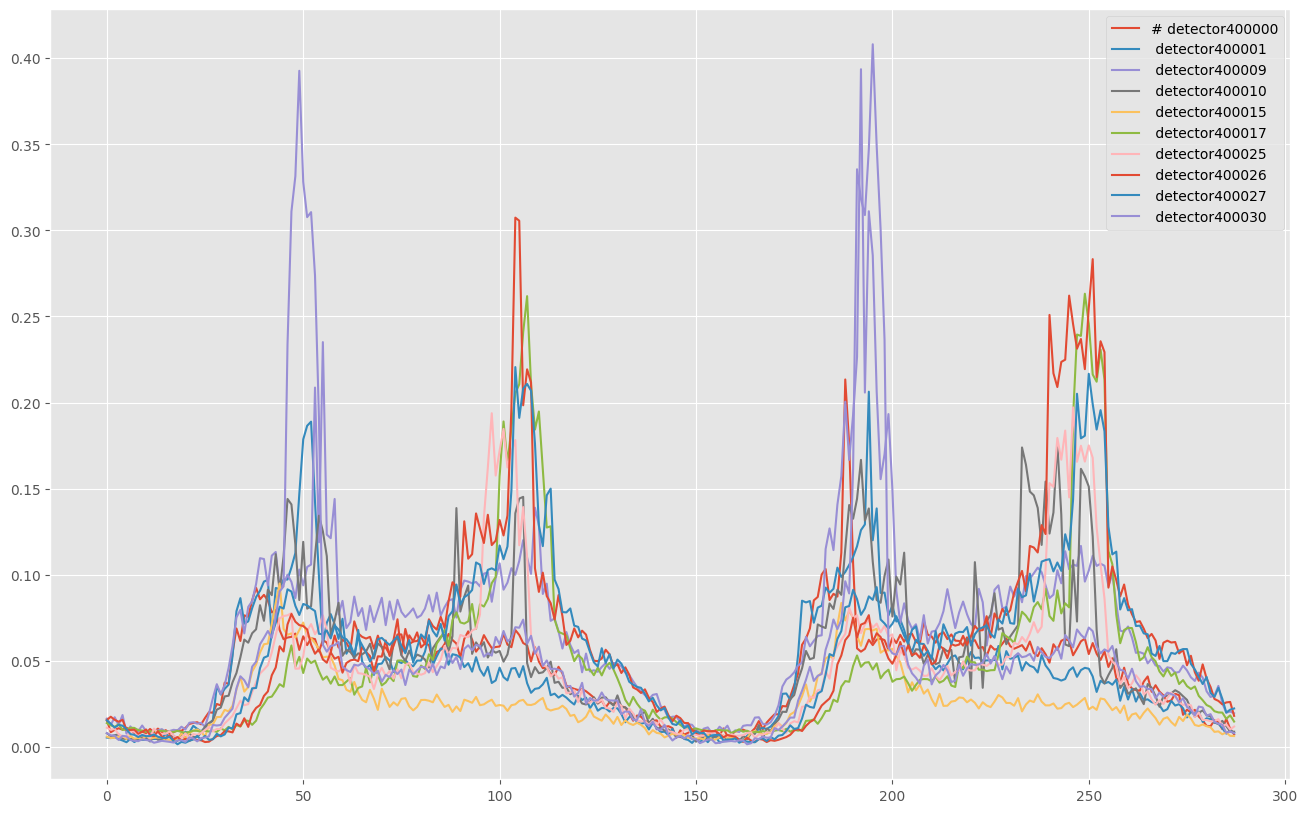

In [21]:
plt.plot(df[:(2*24*6)]); # first 2 days (2*24*6 10-minute intervals) of each of the 10 detectors
plt.legend(df.columns);

Split data into a trainset and a testset (which we wish to forecast):

In [22]:
# convert data to a matrix
y = df.values
N, D = y.shape
print("N=%d, D=%d" % (N,D))

N=1008, D=10


In [23]:
ix_train = range(824, 984)
ix_test = range(984, 1008)
N_train = len(ix_train)
N_test = len(ix_test)
print("N_train:", N_train)
print("N_test:", N_test)
y_train = y[ix_train,:]
y_test = y[ix_test,:]

N_train: 160
N_test: 24


Ok, time to specify our time-series model in NumPyro!

For simplicty, we will start with a simple autoregressive model of order 2, AR(2), of the form:

\begin{align}
z_t &\sim \mathcal{N}(\beta_1 z_{t-1} + \beta_2 z_{t-2}, \tau^2)\\
y_t &\sim \mathcal{N}(z_t, \sigma^2)
\end{align}

Don't forget to assign reasonable priors to $\boldsymbol\beta$, $\tau$ and $\sigma$. We now also need to put priors on the first two latent states $z_1$ and $z_2$. Make sure that you understand why! What if we had an AR(5) model?

An important thing to notice, is that we need to pass an array of length $T$ as input to the Pyro model (corresponding to observations y), where $T$ denotes the number of observations in the time-series. However, we also need to pass it a value ("T_forecast") saying the number of time-steps ahead of $T$ that we wish to forecast. 

Recall that, in order to make predictions, we need to compute the posterior for z[T:T_forecast] and y[T:T_forecast]. Therefore, we then need to propagate the dynamics described in the equations above forwards in time to T:T_forecast.

To be more explicit, the cell below defines a possible pseudo-code for the pyro model we have to implement:


```
Pseudo-Code for AR(2) LDS Model
-------------------------------
def my_pyro_model(T, T_forecast, y=None):
  - Define Priors on beta, tau, sigma, z_1 and z_2
  # Propagate the dynamics over the observed time-series
  - for t in range(T):
      z_t ~ Normal(z_t | beta1*z_t_1 + beta2*z_t_2, tau)
      y_t ~ Normal(y_t | z_t, sigma, obs=y)
  # Propagate the dynamics for prediction
  - for t in range(T, T + T_forecast):
      z_t ~ Normal(z_t | beta1*z_t_1 + beta2*z_t_2, tau)
      y_t ~ Normal(y_t | z_t, sigma, obs=None)
  
```



Make sure the implementation above makes sense (remember: when in doubt, thinking from a generative perspective can be of great help!).

Such implementation would definitely be correct, however, in practice, there is slightly more to it. Using python's `for`-loop in the model will result in long compilation time and computational inefficiencies, which will make this model impractical for almost any interesting problem. 

Luckily, in Pyro there is a way around it. Obviously, this solution will introduce some additional implementation complexity, but it will also give us the ability to develop state-of-the-art temporal models in practice ;)

Concretely, we will replace the `for` loop in our model with the function  `jax.lax.scan`. Meanining, we will use `jax.lax.scan` to iterate over the time-steps of our time-series without explicitly defining a `for`-loop. The cell below roughly describes how `jax.lax.scan` works: 


```
def jax.lax.scan(f, init, xs, length):
  carry = init
  ys = []
  for x in xs:
    carry, y = f(carry, x)
    ys.append(y)
  return carry, np.stack(ys)
```



Let's try to have a look at it more in detail. Essentially, `jax.lax.scan`:
- takes as input 1) a function `f` (representing the computation we want to propagate forward, i.e. the transition probability in our AR model), 2) an `init`ial object which we want to use to propagate `f` forward (something we need to `carry` in order to use `f`), 3) a set of values `xs` which are inputs of `f` and 4) `length` indicating for how many time steps we want to propagate our dynamics forward
- iterates over the `xs` updating the value of `carry` and computing our value of interest `y`.

Ok, this explanation might have been somewhat too abstract. Let's try to be more practical defining it in the context of our AR(2) model. 

What we will do is implement a function `f` that propagates forward in time the dynamics of our model (i.e. computes $z_t$ for $t=1,\ldots$). Let's consider again the model definition described earlier:

\begin{align}
z_t &\sim \mathcal{N}(\beta_1 z_{t-1} + \beta_2 z_{t-2}, \tau^2).\\
\end{align}

We see how $z_t$ can be considered as a function of $\beta_1$, $\beta_2$, $z_{t-1}$, $z_{t-2}$ and $\tau$. It follows, that these will be items which we will have to `carry` if we want to do the computation (concretely, `carry`will be a tuple collecting all these values, e.g. `(beta1, beta2, z_prev1, z_prev2, tau)`). For simplicity, let's ignore the noise term $\tau$. Does the following implementation make sense?

In [24]:
def f_without_noise(carry, x=None):
  beta1, beta2, z_prev1, z_prev2 = carry
  z_t = beta1*z_prev1 + beta2*z_prev2
  z_prev2 = z_prev1
  z_prev1 = z_t
  return (beta1, beta2, z_prev1, z_prev2), z_t

We see how `f_without_noise` is simply propagating forward the mean value for our $z_t$ over time. To be complete however, we must introduce the noise term representing the sampling procedure in the generative process of the model (i.e. $z_t$ is actually sampled from a Normal having mean as computed through `f_without_noise` and with variance $\tau^2$).  

Try running the following cell, can you understand the result?

In [25]:
beta1 = beta2 = 1.
z_prev1 = z_prev2 = 1.
carry = (beta1, beta2, z_prev1, z_prev2)
carry_updated, z_t = f_without_noise(carry, x=None) # propagating the dynamics forward for 1 time step
print("Initial carried items: \nbeta1: {}, beta2: {}, z_prev1: {}, z_prev2: {}".format(carry[0], carry[1], carry[2], carry[3]))
print("Updated carried items: \nbeta1: {}, beta2: {}, z_prev1: {}, z_prev2: {}".format(carry_updated[0], carry_updated[1], carry_updated[2], carry_updated[3]))
print("Computed z_t: {}".format(z_t))

Initial carried items: 
beta1: 1.0, beta2: 1.0, z_prev1: 1.0, z_prev2: 1.0
Updated carried items: 
beta1: 1.0, beta2: 1.0, z_prev1: 2.0, z_prev2: 1.0
Computed z_t: 2.0


If the above makes sense to you we are missing only the last puzzle pieces...

If our `f_without_noise`can be seen as propagating our state $z_t$ and our `carry` forward by one time step, the `jax.lax.scan` function enables us to propagate the dynamics forward for more than one time step and collecting the results. Again, check if the implementation (and results) below make sense to you: 

In [26]:
beta1 = beta2 = 1.
z_prev1 = z_prev2 = 1.
carry = (beta1, beta2, z_prev1, z_prev2)
carry_updated, z_collection = jax.lax.scan(f=f_without_noise, init=carry, xs=None, length=5) # propagating the dynamics forward for 5 time steps
print("Initial carried items: \nbeta1: {}, beta2: {}, z_prev1: {}, z_prev2: {}".format(carry[0], carry[1], carry[2], carry[3]))
print("Final carried items: \nbeta1: {}, beta2: {}, z_prev1: {}, z_prev2: {}".format(carry_updated[0], carry_updated[1], carry_updated[2], carry_updated[3]))
print("Computed z_t (for t=1,...,5):")
for t in range(5):
  print("z{}={}".format(str(t+1), z_collection[t]))

Initial carried items: 
beta1: 1.0, beta2: 1.0, z_prev1: 1.0, z_prev2: 1.0
Final carried items: 
beta1: 1.0, beta2: 1.0, z_prev1: 13.0, z_prev2: 8.0
Computed z_t (for t=1,...,5):
z1=2.0
z2=3.0
z3=5.0
z4=8.0
z5=13.0


At this point, the only missing piece is adding the noise parameter $\tau$ back in the picture. In practice, as explained in class, we do so by re-parametrizing the noise in a parameter `tau` and a vector of `noises` ~ $\mathcal{N}(0, 1)$ for all observed (and predicted) time steps. The final function `f` for our `jax.lax.scan` will be the following:

In [27]:
def f(carry, noise_t):
  beta1, beta2, z_prev1, z_prev2, tau = carry
  z_t = beta1*z_prev1 + beta2*z_prev2 + tau*noise_t
  z_prev2 = z_prev1
  z_prev1 = z_t
  return (beta1, beta2, z_prev1, z_prev2, tau), z_t

Can you put all of this together and define the Pyro Model for the AR(2) model?

In [28]:
def model(T, T_forecast, obs=None):
    """ Define priors over beta1, beta2, tau, noises, sigma, z_prev1 and z_prev2 (keep the shapes in mind)
    # Your code here
    """
    beta2 = numpyro.sample(name='beta_2', fn=dist.Normal(0,5))
    beta1 = numpyro.sample(name='beta_1', fn=dist.Normal(0,5))
    tau = numpyro.sample(name='tau', fn=dist.HalfCauchy(3))
    noises = numpyro.sample(name='noises', fn=dist.Normal(0,1), sample_shape=(T+T_forecast-2,))
    sigma = numpyro.sample(name='sigma', fn=dist.HalfCauchy(3))
    z_prev1 = numpyro.sample(name='z_prev1', fn=dist.Normal(0,3))
    z_prev2 = numpyro.sample(name='z_prev2', fn=dist.Normal(0,3))


    
    """ Propagate the dynamics forward using jax.lax.scan
    carry = (beta1, beta2, z_prev1, z_prev2, tau)
    z_collection = [z_prev1, z_prev2]
    
    """
    carry = (beta1, beta2, z_prev1, z_prev2, tau)
    z_collection = [z_prev1, z_prev2]

    """ Sample the observed_y (y_obs) and predicted_y (y_pred) - note that you don't need a pyro.plate!
    """
    
    carry, zs_exp = lax.scan(f, carry, noises, T+T_forecast-2)
    z_collection = jnp.concatenate((jnp.array(z_collection), zs_exp), axis=0)

    numpyro.sample(name="y_obs", fn=dist.Normal(z_collection[:T], sigma), obs=obs[:T])
    numpyro.sample(name="y_pred", fn=dist.Normal(z_collection[T:], sigma), obs=None)

    return z_collection

Run inference using MCMC:

In [29]:
t0 = time.time()

rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

nuts_kernel = NUTS(model=model, max_tree_depth=8, step_size=5e-3, adapt_step_size=False)
mcmc = MCMC(nuts_kernel, num_samples=3000, num_warmup=1000, num_chains=1)
mcmc.run(rng_key_, T=N_train, T_forecast=N_test, obs=y_train[:,0])

t_fin = time.time()

print("Total time: {0:.3f}m".format((t_fin - t0)/60))

sample: 100%|██████████| 4000/4000 [00:14<00:00, 270.98it/s, 11 steps of size 5.00e-03. acc. prob=0.72] 


Total time: 0.282m


In [30]:
mcmc.print_summary()


                 mean       std    median      5.0%     95.0%     n_eff     r_hat
     beta_1      0.84      0.35      0.75      0.44      1.46     12.93      1.05
     beta_2      0.13      0.34      0.22     -0.48      0.52     12.93      1.05
  noises[0]      0.18      0.79      0.30     -1.13      1.53    120.77      1.00
  noises[1]     -0.23      0.77     -0.30     -1.40      1.15    201.51      1.00
  noises[2]      0.07      0.79      0.16     -1.31      1.23    165.75      1.00
  noises[3]      0.03      0.70     -0.09     -1.26      1.13     74.06      1.01
  noises[4]     -0.04      0.79      0.06     -1.23      1.34     54.73      1.03
  noises[5]     -0.01      0.78      0.03     -1.30      1.27    240.65      1.01
  noises[6]      0.08      0.84      0.19     -1.34      1.32    102.99      1.00
  noises[7]      0.03      0.82     -0.05     -1.18      1.48     31.79      1.08
  noises[8]     -0.02      0.79      0.01     -1.42      1.25    210.87      1.01
  noises[9]    

Extract samples and visualize posterior over beta, tau and sigma:

In [31]:
hmc_samples = {k: v for k, v in mcmc.get_samples().items()}

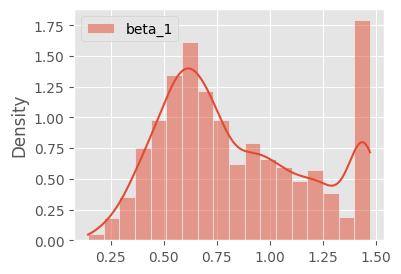

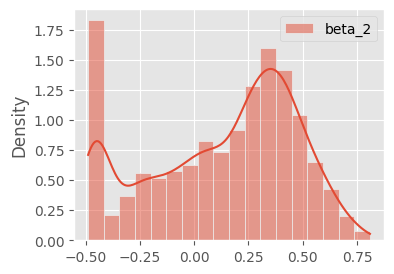

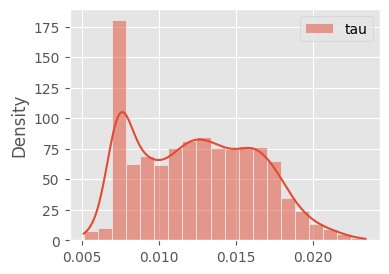

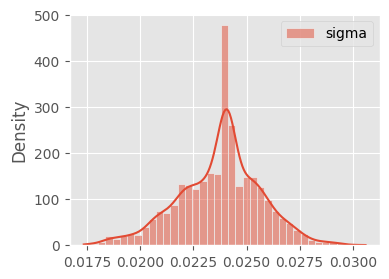

In [32]:
nodes = ["beta_1", "beta_2", "tau", "sigma"]
for node in nodes:
  plt.figure(figsize=(4,3))
  sns.histplot(hmc_samples[node], label=node, kde=True, stat="density")
  plt.legend()
  plt.show()

In [33]:
q = hmc_samples["y_pred"]
q_mean = q.mean(axis=0).reshape(-1,)
q_std = q.std(axis=0).reshape(-1,)
y_pred_025 = q_mean - 1.96*q_std
y_pred_975 = q_mean + 1.96*q_std
y_pred_mean = q_mean

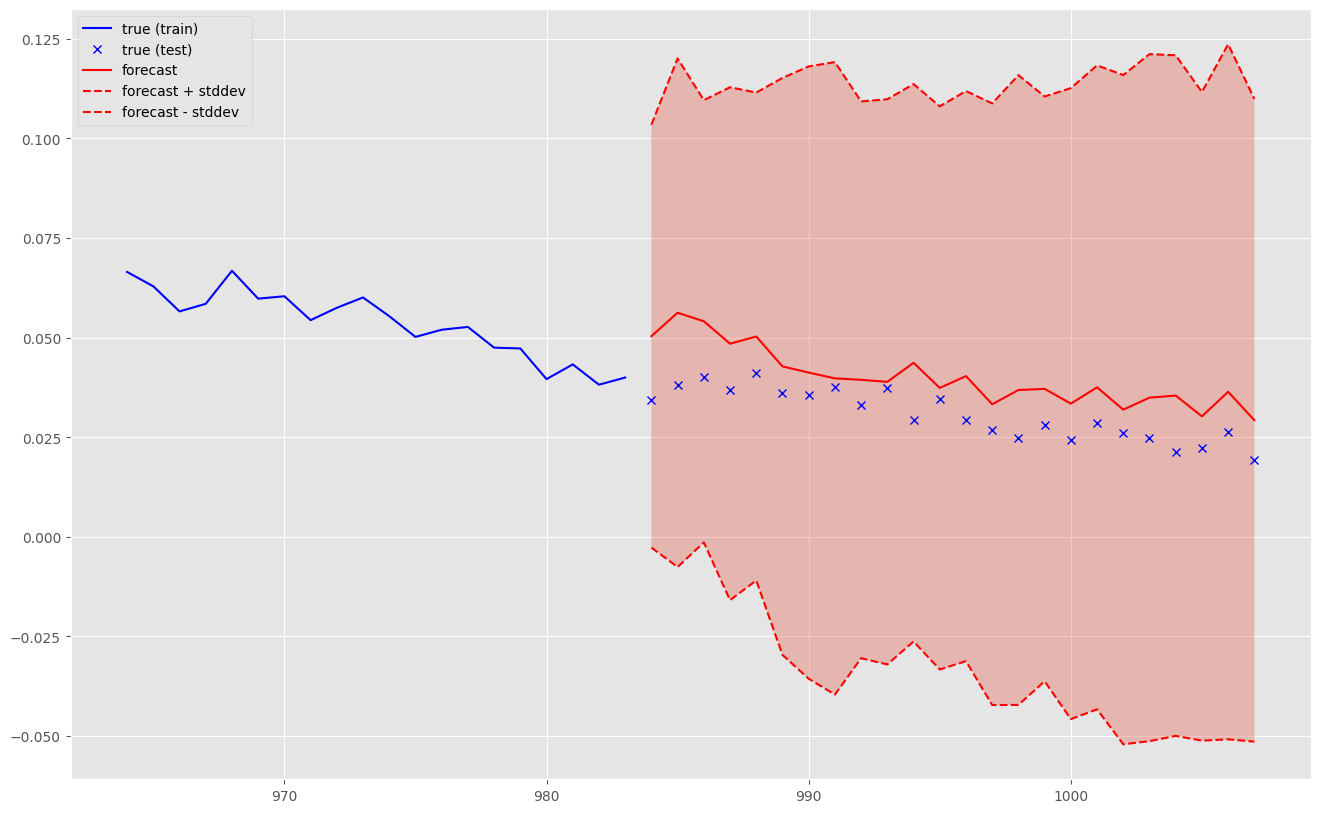

In [34]:
plt.plot(ix_train[-20:], y_train[-20:, 0], "b-")
plt.plot(ix_test, y_test[:, 0], "bx")
plt.plot(ix_test, y_pred_mean, "r-")
plt.plot(ix_test, y_pred_025, "r--")
plt.plot(ix_test, y_pred_975, "r--")
plt.fill_between(ix_test, y_pred_025, y_pred_975, alpha=0.3)
plt.legend(["true (train)","true (test)","forecast","forecast + stddev","forecast - stddev"])
plt.show()

Did you get reasonable predictions? We should not expect amazing results, since your model is still quite simplistic...

Also, notice that in general, the uncertainty on the model's predictions increases as we move away from T. This ability to quantify the uncertainty in the predictions is a major advantage of full Bayesian approaches :-)